In [64]:
%matplotlib inline

import os
import textwrap
import math

import datetime as dt
import pandas as pd

import matplotlib        as mpl
import matplotlib.pyplot as plt

import numpy             as np
import tables            as tb
import seaborn as sns

#import invisible_cities.core.core_functions as coref
#import invisible_cities.core.fit_functions  as fitf

from   scipy.optimize                          import curve_fit
from   scipy                                   import stats

#from   invisible_cities.io.dst_io import df_writer

# Formatting options
pd.options.display.max_columns = None
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['patch.facecolor'] = 'gray'
hargs = {'histtype': 'stepfilled', 'edgecolor': 'black', 'facecolor': 'gray'}

# Directory to which figures will be stored
save_dir = "Trazas"
ftype = "pdf"
if(not os.path.isdir(save_dir)):
    print("Creating directory",save_dir)
    os.mkdir(save_dir)

In [65]:
evtfnames_data = ["/Users/diego/Desktop/DIEGO/USC/TFG/data/ntuple_combined_7746.h5"]
evtfnames_MC   = ["/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6206.h5",
              "/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6207.h5",
              "/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6208.h5",]

In [66]:
cdf = None
for ifile,fname in enumerate(evtfnames_data):

    print("Adding file {} ...".format(fname))

    ftbl = tb.open_file(fname, 'r')
    
    fsummary = ftbl.root.Summary.Events
    fdst = ftbl.root.DST.Events
    ftracks = ftbl.root.Tracking.Tracks

    # Read the tables into DataFrames.
    to_df = pd.DataFrame.from_records
    df_summary = to_df(fsummary.read())
    df_tracks = to_df(ftracks.read())
    df_dst = to_df(fdst.read())
    
    # Drop duplicates in the KDST, selecting the S1 and S2 with highest energy.
    df_dst1 = df_dst.sort_values(['event','S1e','S2e'])[['event','S2e','S1e','nS1','nS2']].drop_duplicates('event',keep='last')
    
    # Drop duplicates in the TDST, selecting the longest tracks.
    # df_tracks = df_tracks.sort_values(['event','length','energy']).drop_duplicates('event',keep='last')
    # Agora non queremos seleccionar a traza máis longa de cada evento, queremos analizalas todas
    
    # Merge into a single dataframe.
    df_merge = pd.merge(df_summary, df_dst1, on = 'event', how='left')
    df_merge = pd.merge(df_merge, df_tracks, on = 'event', how='left')
    
    # Concatenate with previous runs.
    if(cdf is None):
        cdf = df_merge
    else:
        cdf = cdf.append(df_merge)
        
    ftbl.close()

A_evtnum    = cdf['event'].values
A_maxtrklen = cdf['length'].values
A_maxtrkenergy = cdf['energy'].values
A_ntrks     = cdf['evt_ntrks'].values
A_nhits     = cdf['evt_nhits'].values
A_Ec        = cdf['evt_energy'].values
A_xavg      = cdf['evt_x_avg'].values
A_yavg      = cdf['evt_y_avg'].values
A_zavg      = cdf['evt_z_avg'].values
A_ravg      = cdf['evt_r_avg'].values
A_xmin      = cdf['evt_x_min'].values
A_ymin      = cdf['evt_y_min'].values
A_zmin      = cdf['evt_z_min'].values
A_xmax      = cdf['evt_x_max'].values
A_ymax      = cdf['evt_y_max'].values
A_zmax      = cdf['evt_z_max'].values
A_rmin      = cdf['evt_r_min'].values
A_rmax      = cdf['evt_r_max'].values
A_nS1       = cdf['nS1'].values
A_S2e       = cdf['S2e'].values

print("{} total events".format(len(A_evtnum)))

Adding file /Users/diego/Desktop/DIEGO/USC/TFG/data/ntuple_combined_7746.h5 ...
733399 total events


In [67]:
justone_nS = cdf[(cdf.nS1 == 1) & (cdf.nS2 == 1)]

justone_nS.head(10)

,event,evt_energy,evt_charge,evt_ntrks,evt_nhits,evt_x_avg,evt_y_avg,evt_z_avg,evt_r_avg,evt_x_min,evt_y_min,evt_z_min,evt_r_min,evt_x_max,evt_y_max,evt_z_max,evt_r_max,evt_out_of_map,S2e,S1e,nS1,nS2,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,r_min,x_max,y_max,z_max,r_max,x_ave,y_ave,z_ave,r_ave,extreme1_x,extreme1_y,extreme1_z,extreme2_x,extreme2_y,extreme2_z,blob1_x,blob1_y,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,7,0.335598,-1.0,1,36,-135.649480,-27.828993,155.537656,138.684092,-155.0,-45.0,152.674953,125.896783,-125.0,-15.0,157.736506,157.003185,False,84618.867188,81.997467,1,1,0.0,0.335598,20.000000,4.0,32.0,1.0,-145.0,-45.0,152.674953,127.475488,-125.0,-15.0,157.736506,151.822265,-135.688308,-27.876997,155.553153,138.721372,-140.0,-40.0,155.205729,-140.0,-20.0,155.205729,-138.276759,-15.000000,155.982208,-137.166530,-45.000000,155.538388,0.269277,0.211121,0.144800,10.0,10.0,10.0
1,20,0.449683,-1.0,1,58,11.388019,168.250244,244.763036,168.786497,-5.0,155.0,238.861932,155.080624,25.0,185.0,249.482353,186.681547,False,86366.273438,109.920044,1,1,0.0,0.449683,24.142136,7.0,53.0,1.0,-5.0,155.0,238.861932,155.080624,25.0,185.0,249.482353,185.607112,11.255903,168.256899,244.789971,168.777191,10.0,160.0,239.172142,10.0,180.0,249.172142,9.917869,155.000000,241.562674,11.246521,185.000000,247.142565,0.325202,0.258931,0.134450,10.0,10.0,10.0
2,21,0.231753,-1.0,1,30,-47.572942,-2.542974,332.936846,48.134566,-65.0,-15.0,329.015076,35.355339,-35.0,15.0,335.901912,65.192024,False,61307.527344,68.129738,1,1,0.0,0.231753,14.142136,3.0,28.0,1.0,-55.0,-15.0,329.015076,35.355339,-35.0,5.0,335.901912,57.008771,-47.420587,-2.704913,332.936846,47.947807,-50.0,-10.0,332.458494,-40.0,0.0,332.458494,-49.351206,-15.000000,332.672652,-35.000000,-1.618100,332.286847,0.222574,0.195540,0.186361,10.0,10.0,10.0
3,28,NaN,-1.0,1,190,NaN,NaN,NaN,NaN,-205.0,-5.0,269.224555,105.118980,-105.0,55.0,334.883022,206.518764,True,304383.781250,463.642334,1,1,0.0,1.285731,107.566304,50.0,172.0,1.0,-195.0,5.0,271.048179,115.108644,-115.0,55.0,334.883022,198.116128,-154.418321,24.564391,299.920690,156.683581,-190.0,10.0,272.965600,-120.0,10.0,332.965600,-115.000000,5.000000,331.306863,-195.000000,5.000000,273.405236,0.262475,0.135371,0.000000,10.0,10.0,10.0
4,35,0.247732,-1.0,1,28,-33.095697,127.828766,132.349715,132.191430,-45.0,115.0,130.127083,117.686023,-25.0,145.0,134.995363,149.164339,False,57483.855469,63.679695,1,1,0.0,0.247732,20.000000,4.0,27.0,1.0,-45.0,115.0,130.127083,117.686023,-25.0,145.0,134.995363,149.164339,-33.042761,127.891975,132.349715,132.233231,-30.0,120.0,132.561223,-30.0,140.0,132.561223,-32.572454,115.000000,131.959763,-32.138881,145.000000,132.387060,0.203896,0.162763,0.118927,10.0,10.0,10.0
10,52,0.328221,-1.0,1,39,48.967914,2.607150,267.176805,49.555593,35.0,-15.0,263.610989,35.355339,65.0,15.0,270.512300,66.708320,False,85002.062500,98.218796,1,1,0.0,0.328221,20.000000,4.0,35.0,1.0,35.0,-5.0,263.610989,35.355339,65.0,15.0,270.512300,65.192024,48.965581,2.741124,267.159791,49.487159,40.0,0.0,267.061645,60.0,0.0,267.061645,35.000000,0.480983,267.047246,65.000000,0.809730,267.111846,0.280992,0.260370,0.213140,10.0,10.0,10.0
11,57,0.246365,-1.0,1,28,-139.088816,-38.114536,120.667627,144.394985,-155.0,-55.0,119.196154,127.475488,-125.0,-25.0,122.298597,161.400124,False,61756.273438,46.274181,1,1,0.0,0.246365,20.000000,4.0,24.0,1.0,-155.0,-45.0,119.196154,129.807550,-125.0,-25.0,122.298597,161.400124,-138.938487,-37.895084,120.667627,144.165508,-150.0,-40.0,120.747376,-130.0,-40.0,120.747376,-125.000000,-39.712196,120.217116,-155.000000,-38.093645,120.410953,0.221143,0.164979,0.139757,10.0,10.0,10.0
12,61,0.221966,-1.0,1,24,-124.242864,-20.075224,220.393703,126.029877,-135.0,-35.0,218.723342,115.108644,-115.0,-5.0,222.016369,139.463257,False,56574.906250,48.347424,1,1,0.0,0.221966,10.000000,2.0,18.0,1.0,-135.0,-25.0,218.723342,115.974135,-115.0,-15

# Distribución Enerxética das Trazas

(1.4, 1.8)

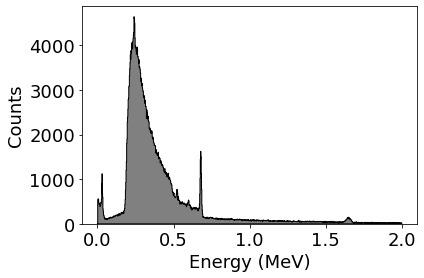

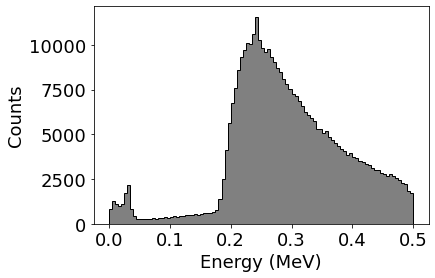

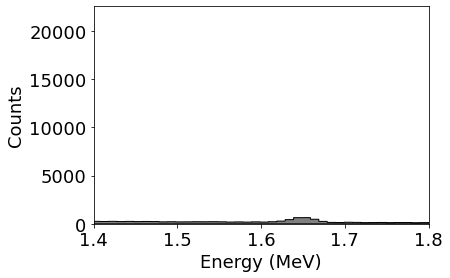

In [68]:
plt.figure(1)

x, y, _ = plt.hist(justone_nS.energy, 1000, range=[0.0,2.0], **hargs)
#plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')


plt.figure(2)

x, y, _ = plt.hist(justone_nS.energy, 100, range=[0.0,0.5], **hargs)
#plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')


plt.figure(3)

x, y, _ = plt.hist(justone_nS.energy, 500, **hargs)
#plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.xlim(1.4,1.8)

#

# Lonxitude en X, Y e Z

Text(0, 0.5, 'Counts')

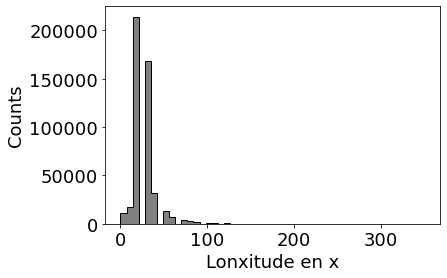

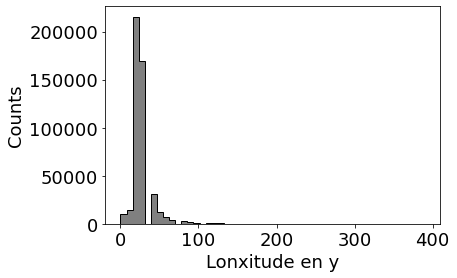

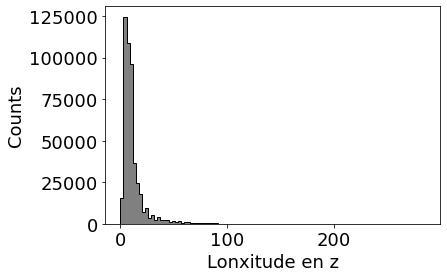

In [69]:
lonxitude_total_x = justone_nS.x_max - justone_nS.x_min
lonxitude_total_y = justone_nS.y_max - justone_nS.y_min
lonxitude_total_z = justone_nS.z_max - justone_nS.z_min

plt.figure(1)

x, y, _ = plt.hist(lonxitude_total_x, 50, **hargs)
#plt.yscale('log')
plt.xlabel('Lonxitude en x')
plt.ylabel('Counts')

plt.figure(2)

x, y, _ = plt.hist(lonxitude_total_y, 50, **hargs)
#plt.yscale('log')
plt.xlabel('Lonxitude en y')
plt.ylabel('Counts')

plt.figure(3)

x, y, _ = plt.hist(lonxitude_total_z, 100, **hargs)
#plt.yscale('log')
plt.xlabel('Lonxitude en z')
plt.ylabel('Counts')

# Lonxitude Total

As primeiras 10093.0 trazas teñen lonxitude 0.0
A traza máis longa mide 475.3444046914554, e hai 1.0 trazas desa lonxitude
DescribeResult(nobs=474542, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


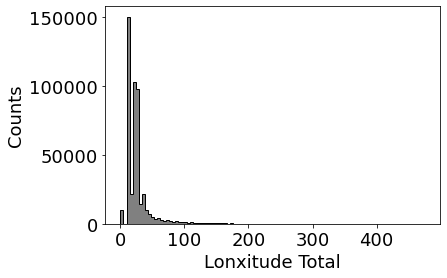

In [70]:
x, y, _ = plt.hist(justone_nS.length, 100, **hargs)
#plt.yscale('log')
plt.xlabel('Lonxitude Total')
plt.ylabel('Counts')
#print('Hai {} trazas de lonxitude ~ 0 m'.format(x[0]))
print('As primeiras {} trazas teñen lonxitude {}'.format(x[0], y[0]))
print('A traza máis longa mide {}, e hai {} trazas desa lonxitude'.format(y[-1], x[-1]))
print(stats.describe(justone_nS.length))

[ 17.60599509  24.31177678  35.28188498  49.04979513  61.52356268
  72.8162233   86.22192424  93.56814887 117.0221595  133.75504668
 151.19229464 167.1173518  182.13634163 194.11170293 388.0190369
 434.4146394  401.45438016 404.086269   425.25761315          nan]

[0.24625 0.43875 0.63125 0.82375 1.01625 1.20875 1.40125 1.59375 1.78625
 1.97875 2.17125 2.36375 2.55625 2.74875 2.94125 3.13375 3.32625 3.51875
 3.71125 3.90375]

[ 5.48788558  7.79801191 11.69019256 18.71715759 22.41584949 24.30722676
 27.68770962 30.090395   35.89765558 40.81501575 46.6132743  50.4619338
 60.05710252 58.31762966 33.9879171   8.78315178 54.23142573  0.
 22.74255595         nan]
None


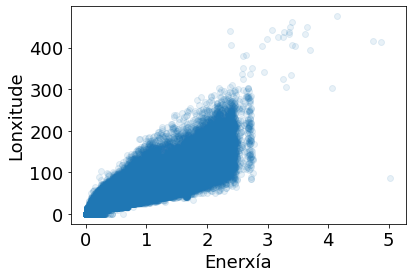

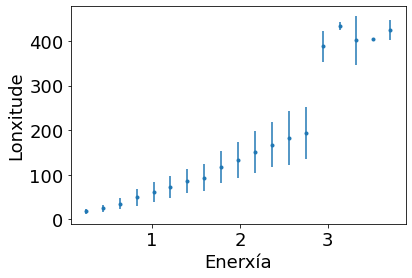

In [71]:
plt.figure(1)
plt.scatter(justone_nS.energy, justone_nS.length, alpha=0.1)
plt.ylabel('Lonxitude')
plt.xlabel('Enerxía')

#HAI UN MONTÓN DE PUNTOS CON LONXITUDE 0 E ENERXÍA QUE VARÍA ENTRE 0 E 0.5 MeV.
#NECESITA UN PROFILE

def profile_plot(x,y, bins=20, range=(0.15, 4)):
    a = []
    b = []
    for i,j in zip(x, y):
        if((not math.isnan(i)) and (not math.isnan(j))):
            a.append(i)
            b.append(j)

    c = np.asarray(a)
    d = np.asarray(b)

    means_result = stats.binned_statistic(c,[d, d**2] , bins=bins, range=range, statistic='mean')
    means, means2 = means_result.statistic
    standard_deviations = np.sqrt(means2 - means**2)
    bin_edges = means_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

    print(means)
    print('')
    print(bin_centers)
    print('')
    print(standard_deviations)

    plt.errorbar(x=bin_centers, y=means, yerr=standard_deviations, linestyle='none', marker='.')
    plt.ylabel('Lonxitude')
    plt.xlabel('Enerxía')

plt.figure(2)
print(profile_plot(justone_nS.energy, justone_nS.length))

# Análise Trazas de Lonxitude = 0

INFORMACIÓN XENERAL SOBRE l0x
DescribeResult(nobs=10093, minmax=(0.0, 10.0), mean=0.9224214802338254, variance=8.374183117223849, skewness=2.818270128487587, kurtosis=5.942646517125443)

CONTAS
0 u: 90.776%; 1 u: 0.000%; 2 u: 0.000%; 3 u: 0.000%; 4 u: 0.000%; 5 u: 0.000%; 6 u: 0.000%; 7 u: 0.000000%; 8 u: 0.000000%; 9 u: 0.000%; 10 u: 9.224%



INFORMACIÓN XENERAL SOBRE l0z
DescribeResult(nobs=10093, minmax=(0.0, 9.954721289674943), mean=1.0785196700965598, variance=2.7558537418890867, skewness=2.383239798125056, kurtosis=6.706434587100308)

CONTAS
0 u: 55.325%; 1 u: 4.250%; 2 u: 31.121%; 3 u: 2.071%; 4 u: 1.793%; 5 u: 2.031%; 6 u: 0.317%; 7 u: 1.863%; 8 u: 0.178341%; 9 u: 1.040325%; 9.94 u: 0.010%



INFORMACIÓN XENERAL SOBRE l0y
DescribeResult(nobs=10093, minmax=(0.0, 10.0), mean=0.9006241949866244, variance=8.19593005029445, skewness=2.8639809395089095, kurtosis=6.2023868218703395)

CONTAS
0 u: 90.994%; 1 u: 0.000%; 2 u: 0.000%; 3 u: 0.000%; 4 u: 0.000%; 5 u: 0.000%; 6 u: 0.000%;7 u

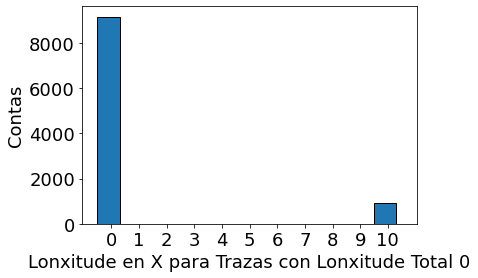

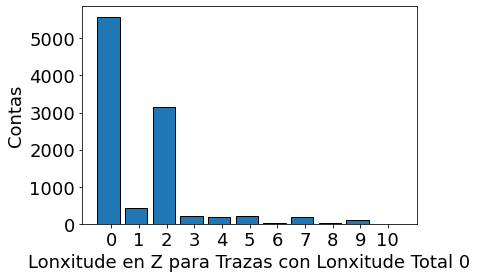

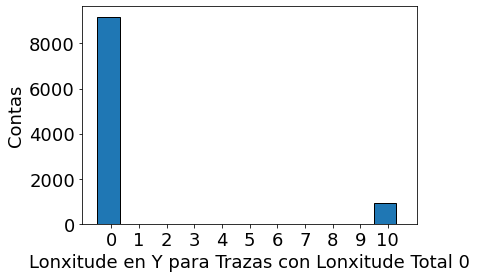

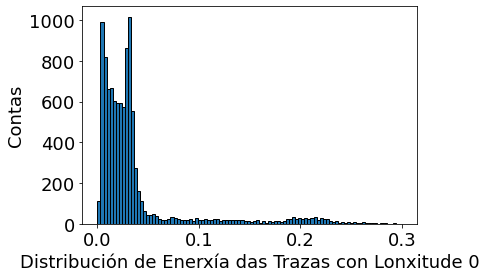

In [72]:
l0 = justone_nS[(justone_nS.length == 0)]


l0x = l0.x_max - l0.x_min
l0y = l0.y_max - l0.y_min
l0z = l0.z_max - l0.z_min


plt.figure(1)

bins = np.arange(start=0, stop=12) - 0.5
n, bins, patches = plt.hist(l0x, bins, edgecolor='black', width=0.8)
plt.xticks(np.arange(start=0, stop=11))
plt.xlabel('Lonxitude en X para Trazas con Lonxitude Total 0')
plt.ylabel('Contas')

#CREO LOS PORCENTAJES
x = stats.describe(l0x)
a = []
for i in range(len(n)):
    a.append((n[i]/x[0])*100)
    
print('INFORMACIÓN XENERAL SOBRE l0x')
print(x)
print('')
print('CONTAS')
print('0 u: {:.3f}%; 1 u: {:.3f}%; 2 u: {:.3f}%; 3 u: {:.3f}%; 4 u: {:.3f}%;'
      ' 5 u: {:.3f}%; 6 u: {:.3f}%; 7 u: {:.6f}%; 8 u: {:.6f}%; 9 u: {:.3f}%; 10 u: {:.3f}%'.format(a[0],a[1],
                                                                                                a[2],a[3],a[4],
                                                                                    a[5],a[6],a[7],a[8],a[9],a[10]))
print('\n\n')


plt.figure(2)

bins = np.arange(start=0, stop=12) - 0.5
n, bins, patches = plt.hist(l0z, bins, edgecolor='black', width=0.8)
plt.xticks(np.arange(start=0, stop=11))
plt.xlabel('Lonxitude en Z para Trazas con Lonxitude Total 0')
plt.ylabel('Contas')

#CREO LOS PORCENTAJES
z = stats.describe(l0z)
b = []
for i in range(len(n)):
    b.append((n[i]/z[0])*100)
    
print('INFORMACIÓN XENERAL SOBRE l0z')
print(z)
print('')
print('CONTAS')
print('0 u: {:.3f}%; 1 u: {:.3f}%; 2 u: {:.3f}%; 3 u: {:.3f}%; 4 u: {:.3f}%; 5 u: {:.3f}%;'
      ' 6 u: {:.3f}%; 7 u: {:.3f}%; 8 u: {:.6f}%; 9 u: {:.6f}%; 9.94 u: {:.3f}%'.format(b[0],b[1],b[2],b[3],b[4],
                                                                                    b[5],b[6],b[7],b[8],b[9],b[10]))
print('\n\n')

plt.figure(3)

bins = np.arange(start=0, stop=12) - 0.5
n, bins, patches = plt.hist(l0y, bins, edgecolor='black', width=0.8)
plt.xticks(np.arange(start=0, stop=11))
plt.xlabel('Lonxitude en Y para Trazas con Lonxitude Total 0')
plt.ylabel('Contas')

#CREO LOS PORCENTAJES
y = stats.describe(l0y)
c = []
for i in range(len(n)):
    c.append((n[i]/y[0])*100)
    
print('INFORMACIÓN XENERAL SOBRE l0y')
print(y)
print('')
print('CONTAS')
print('0 u: {:.3f}%; 1 u: {:.3f}%; 2 u: {:.3f}%; 3 u: {:.3f}%; 4 u: {:.3f}%; 5 u: {:.3f}%; 6 u: {:.3f}%;'
      '7 u: {:.3f}%; 8 u: {:.6f}%; 9 u: {:.6f}%; 10 u: {:.3f}%'.format(c[0],c[1],c[2],c[3],c[4],c[5],c[6],
                                                                       c[7],c[8],c[9],c[10]))



plt.figure(4)

#bins = np.arange(start=0, stop=0.5) - 0.5
n, bins, patches = plt.hist(l0.energy, bins=100, edgecolor='black', range=[0, 0.3])
#plt.xticks(np.arange(start=0, stop=11))
plt.xlabel('Distribución de Enerxía das Trazas con Lonxitude 0')
plt.ylabel('Contas')

print('\n\n')
print('INFORMACIÓN SOBRE A DISTRIBUCIÓN ENERXÉTICA DAS TRAZAS CON LONXITUDE TOTAL 0')
print(stats.describe(l0.energy))

In [73]:
l0
l0.z_max.head(20)

38      169.739879
327     145.921085
347     201.122194
353     136.987085
386     265.964827
455     149.536693
485     195.644457
564     247.834609
599     198.621141
624     156.787018
634     114.251378
695     188.501296
746      23.932309
749     471.833432
878     179.018429
916     118.313036
959     165.333556
963     112.864421
1010    108.260934
1022    279.809103
Name: z_max, dtype: float64

# Posición Absoluta das Trazas con Lonxitude 0

Lo que haré aquí será hacer un *plot* de las 3 posiciones *x_max*, *y_max* y *z_max* ya que serán iguales a las mínimas por ser la longitud total cero. Con esto pretendo entender si las trazas con longitud total cero que vemos tan numerosas son simplemente "puntos" en las paredes de la cámara.

In [74]:
from mpl_toolkits import mplot3d

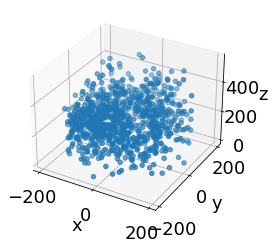

In [75]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(l0.x_max[38:1022], l0.y_max[38:1022], l0.z_max[38:1022]) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Como podemos ver na figura de arriba, a distribución das trazas puntuais de lonxitude 0 toma forma de "tambor", de xeito que estas aparecen difuminadas por toda a cámara onde se realiza o experimento. Así, a hipótese que as trazas de lonxitude 0 eran puntuais e estaban repartidas polas paredes da cámara queda descartada. Fagamos un análise da posición absoluta en 2D.

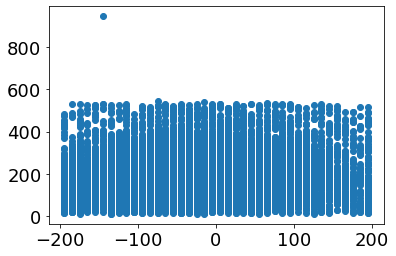

In [76]:
plt.scatter(l0.x_max, l0.z_max)

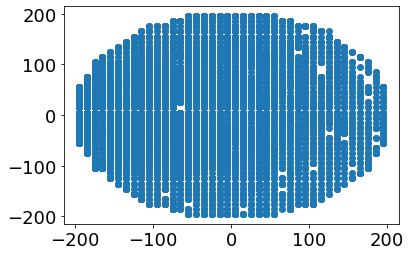

In [77]:
plt.scatter(l0.x_max, l0.y_max)

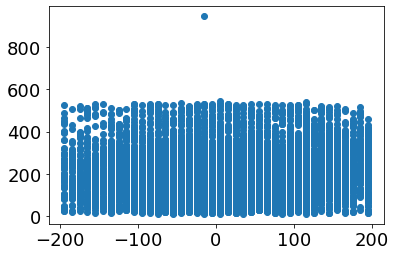

In [78]:
plt.scatter(l0.y_max, l0.z_max)

Non sei se estou facendo exactamente o que debería estar facendo, pero se si, a única conclusión extraíble paréceme que é que as trazas de lonxitude 0 están distribuídas uniformemente por toda a cámara.